# Image Captioning with Visual Attention (TF Core Tutorial)

https://hub.packtpub.com/generating-automated-image-captions-using-nlp-and-computer-vision-tutorial/

https://www.tensorflow.org/tutorials/text/image_captioning

In [1]:
# Import TensorFlow and enable eager execution
import tensorflow as tf
from tensorflow import keras

In [2]:
# In Tensorflow 2.0, eager execution is enabled by default.
tf.executing_eagerly()

True

In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# Image and Caption Data Loading

In [4]:
annotation_file = os.path.abspath('cocoapi/annotations/captions_train2014.json')  # point to annotations in root of notebook
PATH = os.path.abspath('/Users/bwilke/Desktop/images/train2014/') # way to big for my cloud storage drive where notebook lives, so point to local machine

In [5]:
PATH

'/Users/bwilke/Desktop/images/train2014'

In [6]:
# read the json annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [21]:
# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

# extract caption and image ID to form full path from raw JSON annotations
for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + '/COCO_train2014_{:012d}.jpg'.format(image_id)

    # adds the path and corresponding caption to shared index across 2 lists
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together; setting a random state
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = 1)

# selecting the first 40000 captions/images from the shuffled sey by replacing with sliced set
num_examples = 1000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [22]:
# train captions example
train_captions[400]

'<start> A woman in the kitchen fumbles with a pizza cardboard.  <end>'

In [23]:
# training image name vector example
img_name_vector[400]

'/Users/bwilke/Desktop/images/train2014/COCO_train2014_000000255849.jpg'

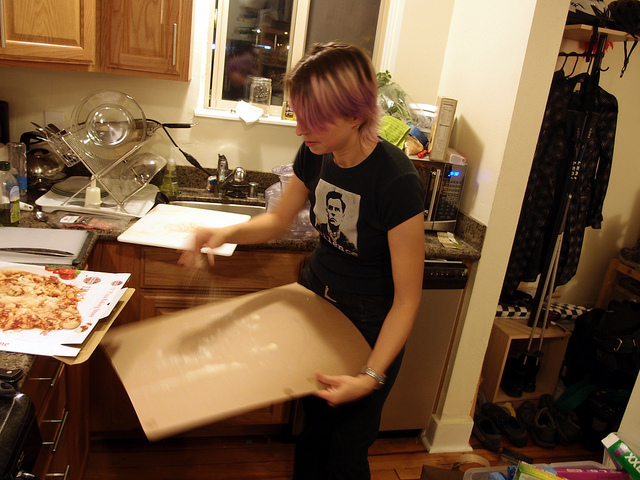

In [24]:
Image.open(img_name_vector[400])

In [25]:
# train captions example
train_captions[401]

'<start> There are some ducks swimming in some water <end>'

In [26]:
# training image name vector example
img_name_vector[401]

'/Users/bwilke/Desktop/images/train2014/COCO_train2014_000000071856.jpg'

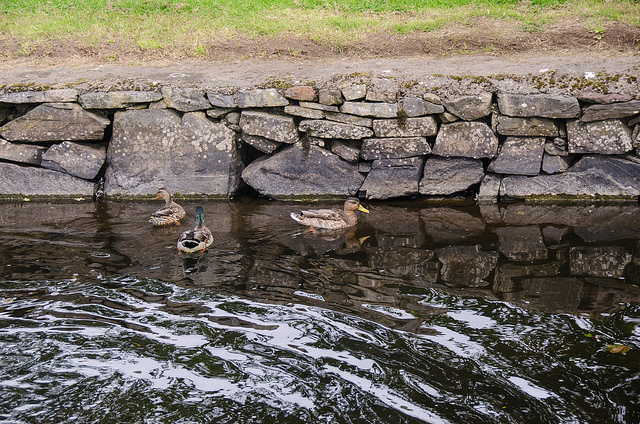

In [27]:
Image.open(img_name_vector[401])

In [28]:
len(train_captions), len(all_captions)

(1000, 414113)

## Image Loader, CNN Model, and Image Feature Extraction

Define a function to take an image and prep it for CNN

In [29]:
def load_image(image_path):
    img = tf.io.read_file(image_path)                         # gets image from path    
    img = tf.image.decode_jpeg(img, channels=3)               # decodes JPG
    img = tf.image.resize(img, (299, 299))                    # resize
    img = tf.keras.applications.inception_v3.preprocess_input(img)   # preprocess for inceptionV3
    return img, image_path

In [32]:
# show output shape of load_image function
load_image(img_name_vector[401])[0].shape

TensorShape([299, 299, 3])

In [33]:
# initialize Inception-V3 with ImageNet weights
image_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')  # loads pretrained model

In [34]:
# this is our CNN where output layer is the last layer in Inception-V3
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# image_features_extract_model is our new deep CNN encoder, which is responsible for learning
# the features from the given image.
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


Caching Features

This will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

In [ ]:
encode_train = sorted(set(img_name_vector))                # sort unique entries in img_name_vector

# for each image path in encode_train, apply load_image(), returns tensor
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract features
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)           # forward feed the image tensor through the model
    # reshape the output
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    # save each output to disk 
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())    

# Data Preparation for RNN Decoder

In [35]:
# Helper func to find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Performing tokenization on the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k, oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Converting text into sequence of numbers
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

#tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items() if value <= top_k} # putting  token in the word2idx dictionary

# putting <unk> token in the word2idx dictionary
#tokenizer.word_index[tokenizer.oov_token] = top_k + 1
#tokenizer.word_index['<pad>'] = 0
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# creating a reverse mapping (index -> word)
#index_word = {value:key for key, value in tokenizer.word_index.items()}

# padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# calculating the max_length used to store the attention weights
max_length = calc_max_length(train_seqs)

In [36]:
# result is a list of lists containing our encoded captions
cap_vector[1]

array([  3,   2,  29, 725,  79,   7, 182,   6, 111,   4,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [37]:
cap_vector[2]

array([  3,   2, 392, 252,  10,  27, 726, 727, 337,  39,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [39]:
# split 80/20 training and validation, where images are X and captions are Y
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size = 0.2, random_state = 69)

In [40]:
# Checking the sample counts
print ("No of Training Images:",len(img_name_train))
print ("No of Training Caption: ",len(cap_train))
print ("No of Training Images",len(img_name_val))
print ("No of Training Caption:",len(cap_val))

No of Training Images: 800
No of Training Caption:  800
No of Training Images 200
No of Training Caption: 200


## Setting Up Data Pipeline

In [41]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# Defining parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [42]:
# shape of the vector extracted from Inception-V3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

# loading the numpy files 
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

#We use the from_tensor_slices to load the raw data and transform them into the tensors
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Using the map() to load the numpy files in parallel
# NOTE: Make sure to set num_parallel_calls to the number of CPU cores you have
# https://www.tensorflow.org/api_docs/python/tf/py_func
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Defining the Captioning Model

Features extracted from lower convolutional layer of Inception-v3 is (8,8,2048)

This is unrolled to (64,2048)

Then passed to single dense layer of CNN encoder, RNN attends over image to predict next word

In [ ]:
def gru(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')

## Attention

Implement the attention mechanism known as Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf)

Takes the features from the CNN encoder of a shape of (batch_size, 64, embedding_dim).

This attention mechanism will return the context vector and the attention weights over the time axis.

In [43]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## CNN Encoder, RNN Decoder, Loss Function

In [44]:
# CNN encoder that will be the single, fully connected layer followed by the ReLU activation:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [49]:
# RNN decoder which will take the encoded features from the encoder.
# The features are fed into the attention layer, which is concatenated with the input embedding vector.
# Then, the concatenated vector is passed into the GRU module, which is further passed through two fully connected layers

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences = True, return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [56]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [57]:
# instantiate our encoder, decoder, and optimizer
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [58]:
# Adam optimizer to train the model and masking the loss calculated for the <PAD> key
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [59]:
# https://www.tensorflow.org/guide/checkpoint
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

In [60]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training the Captioning Model

First, extract features we saved to .npy files and pass each through CNN encoder.

Then encoder output, hidden state(init to 0), and the decoder input (which is start token) are passed to decoder.

Decoder returns predictions and the decoder hidden state.

Decoder hidden state is passed back to the model and predictions are used to calculate loss.

Teacher forcing technique is used to decide next input to decoder.

Teacher forcing is the technique where the target word is passed as the next input to the decoder.

Finally, calculate gradient and apply it the optimizer and back prop.

In [53]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [61]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [62]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8708


ValueError: in converted code:

    <ipython-input-54-ed2ac5f6c6b5>:16 train_step  *
        predictions, hidden, _ = decoder(dec_input, features, hidden)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    <ipython-input-56-8db96461961e>:23 call  *
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1431 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py:1257 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:548 create_op
        compute_device)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:3429 _create_op_internal
        op_def=op_def)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1773 __init__
        control_input_ops)
    /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension 0 in both shapes must be equal, but are 32 and 64. Shapes are [32,1] and [64,1]. for 'rnn__decoder_2/concat' (op: 'ConcatV2') with input shapes: [32,1,256], [64,1,256], [] and with computed input tensors: input[2] = <-1>.


In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()